# Regressão e Classificação com TensorFlow

In [1]:
# Adaptação para utilizar a sintaxe do TensorFlor 1.x no TensorFlow 2.x
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_absolute_error

<br/> 
## 1. Construção de Regressor Linear

### 1.1 Regressão Linear Simples

In [3]:
# Incialização dos Dados
idade = np.array([[18], [23], [28], [33], [38], [43], [48], [53], [58], [63]])
custo = np.array([[871], [1132], [1042], [1356], [1488], [1638], [1569], [1754], [1866], [1900]])

In [4]:
# Escalonamento dos Dados
scaler_x = StandardScaler()
idade_scaled = scaler_x.fit_transform(idade)

scaler_y = StandardScaler()
custo_scaled = scaler_y.fit_transform(custo)

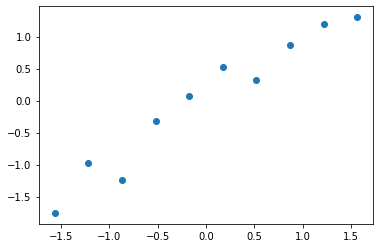

In [5]:
plt.scatter(idade_scaled, custo_scaled)
plt.show()

**Formula da Regressão Linear**

 y = b0 + b1*x

In [6]:
# Incializa valores aleatórios para b0 e b1
np.random.seed(0)
random_value = np.random.rand(2)
b0_initial_value = random_value[0]
b1_initial_value = random_value[1]

b0 = tf.Variable(b0_initial_value, name='intercept')
b1 = tf.Variable(b1_initial_value, name='coef')

In [7]:
# Cria a função de regressao
prediction = tf.add(b0, b1 * idade_scaled, name='regression_eq')

# Define a função custo
erro = tf.losses.mean_squared_error(custo_scaled, prediction)

# Cria o otimizador (algoritmo responsável pela redução da função de custo)
otimizador = tf.train.GradientDescentOptimizer(learning_rate=0.001)

# Treinamento = otimizador buscando minimizar a função de custo
treinamento = otimizador.minimize(erro)

In [8]:
# Define o numero de epochs a ser treinado o regressor
epochs = 1100

In [9]:
var_init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(var_init)
    for i in range(epochs):
        sess.run(treinamento)
    
    b0_final, b1_final = sess.run((b0, b1))

Regressor: 0.0607 + 0.9429*x


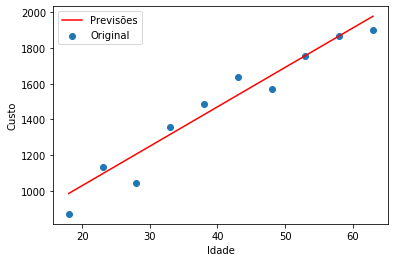

In [10]:
print('Regressor: {:.4f} + {:.4f}*x'.format(b0_final, b1_final))

previsoes = b0_final + b1_final*idade_scaled
previsoes = scaler_y.inverse_transform(previsoes)

# Visualiza Função de Regressão
plt.scatter(idade, custo, label='Original')
plt.plot(idade, previsoes, color='red', label='Previsões')
plt.xlabel('Idade')
plt.ylabel('Custo')
plt.legend()
plt.show()

In [11]:
# Avaliação do Erro
# valores original: custo
# valores previsto: previsoes
erro = mean_absolute_error(custo, previsoes)
erro

67.91085758296438

In [12]:
# Prever novos registros
novo_registro = [[40], [50]]
nova_previsao = scaler_y.inverse_transform(b0_final + b1_final*scaler_x.transform(novo_registro))
nova_previsao

array([[1470.95852689],
       [1691.58431553]])

<br/> 
### 1.2 Regressão Linear Simples (Preço de Casas)

In [13]:
data = pd.read_csv('house_prices.csv')
data.shape

(21613, 21)

In [14]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [15]:
# Divisão entre atributos previsores e target
x = data.iloc[:, 5:6].values
y = data.iloc[:, 2:3].values

In [16]:
# Escalonamento dos Dados
scaler_x = StandardScaler()
x_scaled = scaler_x.fit_transform(x)

scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y)

#### 1.2.1 Low Level API

In [17]:
# Define o numero de epochs a ser treinado o regressor e o batch_size
epochs = 10000
batch_size = 32

In [18]:
# Incializa valores aleatórios para b0 e b1
np.random.seed(1)
random_value = np.random.rand(2)
b0_initial_value = random_value[0]
b1_initial_value = random_value[1]

b0 = tf.Variable(b0_initial_value, name='intercept')
b1 = tf.Variable(b1_initial_value, name='coef')

In [19]:
# Cria os placeholders que receberão os valores de entrada e o target
# é definido o tamanho pelo batch_size para evitar sobrecarga na memória
# o que poderia acontecer se fosse carregado todos os dados do dataset de uma vez só
x_ph = tf.placeholder(tf.float64, shape=(batch_size, 1))
y_ph = tf.placeholder(tf.float32, shape=(batch_size, 1))

In [20]:
# Cria a função de regressao
prediction = tf.add(b0, b1*x_ph)

# Define a função custo
erro = tf.losses.mean_squared_error(y_ph, prediction)

# Cria o otimizador (algoritmo responsável pela redução da função de custo)
otimizador = tf.train.GradientDescentOptimizer(learning_rate=0.001)

# Treinamento = otimizador buscando minimizar a função de custo
treinamento = otimizador.minimize(erro)

In [21]:
init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    for i in range(epochs):
        # Seleciona aleatoriamente os indices dos registros que serão utilizados para preencher os placeholders
        indices = np.random.randint(len(x), size=batch_size)
        feed = {x_ph: x_scaled[indices], y_ph : y_scaled[indices]}
        
        sess.run(treinamento, feed_dict=feed)
    
    b0_final, b1_final = sess.run((b0, b1))

Regressor: -0.0031 + 0.6989*x


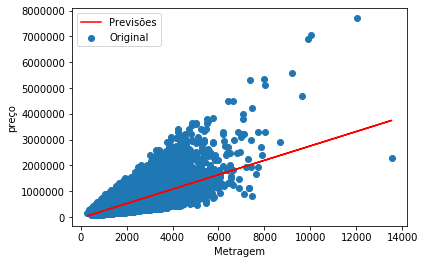

In [22]:
print('Regressor: {:.4f} + {:.4f}*x'.format(b0_final, b1_final))

previsoes = b0_final + b1_final*x_scaled
previsoes = scaler_y.inverse_transform(previsoes)

# Visualiza Função de Regressão
plt.scatter(x, y, label='Original')
plt.plot(x, previsoes, color='red', label='Previsões')
plt.xlabel('Metragem')
plt.ylabel('preço')
plt.legend()
plt.show()

In [23]:
# Avaliação do Erro
# valores original: custo
# valores previsto: previsoes
erro = mean_absolute_error(y, previsoes)
erro

173392.87473489274

#### 1.2.2 High Level API (Estimators)

In [24]:
# Divisão entre dados de treino e test
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.3)

In [25]:
# Cria as colunas de atributos previsores
colunas = [tf.feature_column.numeric_column('metragem', shape=(1,))]

# Cria o regressor
regressor = tf.estimator.LinearRegressor(feature_columns=colunas)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmpn3wzcunj', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [26]:
# Define as funções de treinamento e teste
funcao_train = tf.estimator.inputs.numpy_input_fn({'metragem' : x_train}, y_train, 
                                                  batch_size=32, num_epochs=None, shuffle=True)
 # shuffle: seleciona aleatoriamente n registros para servirem para treinamento
    
funcao_test = tf.estimator.inputs.numpy_input_fn({'metragem' : x_test}, y_test, 
                                                 batch_size=32, num_epochs=1000, shuffle=False)

In [ ]:
# Realiza o treinamento
regressor.train(input_fn=funcao_train, steps=10000)

In [ ]:
# Computa as metricas para avaliação dos resultados
metric_train = regressor.evaluate(input_fn=funcao_train, steps=10000)

metric_test = regressor.evaluate(input_fn=funcao_test, steps=10000)

In [29]:
metric_train

{'average_loss': 0.52459985,
 'label/mean': -0.0012128556,
 'loss': 16.787195,
 'prediction/mean': -0.011552977,
 'global_step': 10000}

In [30]:
metric_test

{'average_loss': 0.4672262,
 'label/mean': 0.0028933124,
 'loss': 14.951239,
 'prediction/mean': -0.0091436785,
 'global_step': 10000}

In [31]:
# Prever novos registros
novo_registro = np.array([[800], [900], [1000]])
novo_registro_scaled = scaler_x.transform(novo_registro)

In [32]:
# Define função de previsão
funcao_predict = tf.estimator.inputs.numpy_input_fn({'metragem' : novo_registro_scaled}, shuffle=False)

In [33]:
previsao_gen = regressor.predict(input_fn=funcao_predict)
list(previsao_gen)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmpn3wzcunj/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([-0.9966888], dtype=float32)},
 {'predictions': array([-0.9196626], dtype=float32)},
 {'predictions': array([-0.84263635], dtype=float32)}]

In [34]:
# regressor.predict retorna uma lista de dicionarios com chave='prediction'
nova_previsao = []
for previsao in regressor.predict(input_fn=funcao_predict):
    nova_previsao.append(scaler_y.inverse_transform(previsao['predictions']))

nova_previsao

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmpn3wzcunj/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[array([174185.05], dtype=float32),
 array([202462.8], dtype=float32),
 array([230740.58], dtype=float32)]

<br/> 
### 1.3 Regressão Linear Múltipla com Estimators (Preço de Casas)

In [35]:
data = pd.read_csv('house_prices.csv')
data.shape

(21613, 21)

In [36]:
data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [37]:
# Divisão entre atributos previsores e target
x = data.iloc[:, 3:19]
y = data.iloc[:, 2:3]

In [38]:
# Escalonamento dos Dados
scaler_x = MinMaxScaler(feature_range=(0,1))
x_scaled = scaler_x.fit_transform(x)
x_scaled = pd.DataFrame(x_scaled, columns = x.columns)

scaler_y = MinMaxScaler(feature_range=(0,1))
y_scaled = scaler_y.fit_transform(y)
y_scaled = pd.Series(y_scaled.reshape(-1,))

In [39]:
x_train, x_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.3)

In [40]:
# Cria as colunas de atributos previsores
colunas = [tf.feature_column.numeric_column(key=col) for col in list(x.columns)]

# Cria o regressor
regressor = tf.estimator.LinearRegressor(feature_columns=colunas)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmp2wkva_9i', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [41]:
# Define as funções de treinamento, teste e previsão
funcao_train = tf.estimator.inputs.pandas_input_fn(x=x_train, y=y_train, 
                                                   batch_size=32, num_epochs=None, shuffle=True)

funcao_test = tf.estimator.inputs.pandas_input_fn(x=x_test, y=y_test,
                                                batch_size=32, num_epochs=10000, shuffle=False)

funcao_predict = tf.estimator.inputs.pandas_input_fn(x=x_test, shuffle=False)

In [42]:
# Realiza o treinamento
regressor.train(input_fn=funcao_train, steps=1000)

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmp2wkva_9i/model.ckpt.
INFO:tensorflow:loss = 0.6567801, step = 1
INFO:tensorflow:global_step/sec: 242.103
INFO:tensorflow:loss = 0.015578181, step = 101 (0.418 sec)
INFO:tensorflow:global_step/sec: 419.694
INFO:tensorflow:loss = 0.012911577, step = 201 (0.238 sec)
INFO:tensorflow:global_step/sec: 302.847
INFO:tensorflow:loss = 0.012378752, step = 301 (0.330 sec)
INFO:tensorflow:global_step/sec: 314.535
INFO:tensorflow:loss = 0.019953292, step = 401 (0.317 sec)
INFO:tensorflow:global_step/sec: 341.175
INFO:tensorflow:loss = 0.01103822, step = 501 (0.293 sec)
INFO:tensorflow:global_step/sec: 354.732
INFO:tensorflow:loss = 0.010176478, step = 601 (0.281 sec)
IN

In [ ]:
# Computa as metricas para avaliação dos resultados
metric_train = regressor.evaluate(input_fn=funcao_train, steps=10000)

metric_test = regressor.evaluate(input_fn=funcao_test, steps=10000)

In [44]:
metric_train

{'average_loss': 0.0007382717,
 'label/mean': 0.061315227,
 'loss': 0.023624694,
 'prediction/mean': 0.05779429,
 'global_step': 1000}

In [45]:
metric_test

{'average_loss': 0.0006881642,
 'label/mean': 0.06023972,
 'loss': 0.022021255,
 'prediction/mean': 0.057131633,
 'global_step': 1000}

In [46]:
previsao_gen = regressor.predict(input_fn=funcao_predict)
list(previsao_gen)[0:5]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmp2wkva_9i/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'predictions': array([0.08452937], dtype=float32)},
 {'predictions': array([0.05609222], dtype=float32)},
 {'predictions': array([0.234352], dtype=float32)},
 {'predictions': array([0.02839268], dtype=float32)},
 {'predictions': array([0.05364102], dtype=float32)}]

In [47]:
# Realiza a previsão
previsoes_scaled = []
for previsao in regressor.predict(input_fn=funcao_predict):
    previsoes_scaled.append(previsao['predictions'])

previsoes_scaled = np.array(previsoes_scaled).reshape(-1, 1)
previsoes = scaler_y.inverse_transform(previsoes_scaled)
previsoes

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmp2wkva_9i/model.ckpt-1000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


array([[ 719536.44],
       [ 502703.2 ],
       [1861933.9 ],
       ...,
       [ 217020.3 ],
       [1002595.9 ],
       [ 688317.7 ]], dtype=float32)

In [48]:
# Computa o erro
y_test_unscaled = scaler_y.inverse_transform(y_test.values.reshape(-1, 1))

erro = mean_absolute_error(y_test_unscaled, previsoes)
erro

123259.96605677195

<br/><br/> 
## 2. Construção de Classificador

### 2.1 Regressão Logística com Estimators

In [49]:
data = pd.read_csv('census.csv')
data.shape

(32561, 15)

In [50]:
data.head()

,age,workclass,final-weight,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loos,hour-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [51]:
# Divisão entre atributos previsores e target
x = data.iloc[:, 0:14]
y = data.iloc[:, 14]

In [52]:
x.columns

Index(['age', 'workclass', 'final-weight', 'education', 'education-num',
       'marital-status', 'occupation', 'relationship', 'race', 'sex',
       'capital-gain', 'capital-loos', 'hour-per-week', 'native-country'],
      dtype='object')

In [53]:
# Preprocessamento nas colunas

# Label encoder da variavel target
y = y.map({' >50K': 1, ' <=50K' : 0})

# Segmentação da idade em buckets
idade = tf.feature_column.numeric_column('age')
idade_categorical = [tf.feature_column.bucketized_column(idade, boundaries=[20,30,40,50,60,70,80,90])]

# Label encoder das colunas categoricas
nome_colunas_categorical = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
colunas_categorical = [tf.feature_column.categorical_column_with_vocabulary_list(key=c, vocabulary_list=x[c].unique()) for c in nome_colunas_categorical]

# Coleta as colunas numericas
nome_colunas_numericas = ['final-weight', 'education-num', 'capital-gain', 'capital-loos', 'hour-per-week']
colunas_numericas = [tf.feature_column.numeric_column(key=c) for c in nome_colunas_numericas]

In [54]:
# Cria as colunas de atributos previsores
colunas = idade_categorical + colunas_categorical + colunas_numericas

# Cria o classificador
classificador = tf.estimator.LinearClassifier(feature_columns=colunas)

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': '/var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmpsdxtdaz5', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [55]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3)

In [56]:
# Define as funções de treinamento e previsão
funcao_train = tf.estimator.inputs.pandas_input_fn(x=x_train, y=y_train,
                                                  batch_size=32, num_epochs=None, shuffle=True)

funcao_predict = tf.estimator.inputs.pandas_input_fn(x=x_test, batch_size=32, shuffle=False)

In [ ]:
# Realiza o treinamento
classificador.train(input_fn=funcao_train, steps=10000)

In [59]:
previsao_gen = classificador.predict(input_fn=funcao_predict)
list(previsao_gen)[0:5]

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /var/folders/ps/3gh7bfwd77b_xjwn226rnrqw0000gn/T/tmpsdxtdaz5/model.ckpt-10000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


[{'logits': array([4428.125], dtype=float32),
  'logistic': array([1.], dtype=float32),
  'probabilities': array([0., 1.], dtype=float32),
  'class_ids': array([1]),
  'classes': array([b'1'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-764.6146], dtype=float32),
  'logistic': array([0.], dtype=float32),
  'probabilities': array([1., 0.], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-611.0081], dtype=float32),
  'logistic': array([0.], dtype=float32),
  'probabilities': array([1., 0.], dtype=float32),
  'class_ids': array([0]),
  'classes': array([b'0'], dtype=object),
  'all_class_ids': array([0, 1], dtype=int32),
  'all_classes': array([b'0', b'1'], dtype=object)},
 {'logits': array([-58.51935], dtype=float32),
  'logistic': array([3.8491

In [ ]:
# Realiza a previsão
previsoes = []
for previsao in classificador.predict(input_fn=funcao_predict):
    previsoes.append(previsao['class_ids'])

previsoes

In [61]:
# Avalia a precisão
score = accuracy_score(y_test, previsoes)
score

0.7923021803664654